Steps:
1. Generate a Rayleigh channel with Jakes Process as done earlier, find its autocorrelation
2. Convert this to Magnitude Phase representation, figure out the autocorrelation
3. Use Mag Phase rep to do this: 
send some packets with headers, estimate the header, then use these header values in a AR process to predict the next AR values sequentuially until the channel estimated is very off, ad then go back to pilots. Claculate frequency of transmitting pilots and plot against doppler frrequency. 
Then do for adaptive AR, with adjusting the parameters. 

BER is a better metric
Fix y axis to represent the number of pilots/number of packets
Estimate the duration, save the numbers, plot against doppler frequency

SNR of 10 dB
1. AR order of 20 - 25 is good, half of coherence window - at lower doppler the performance is good, at higher doppler the performance is not that good as AR tries to correlate packets that are not correlated. 
2. And then plot out the thresholds with the doppler at 4-5 threshold - 0.01 to 0.1.  
3. Robust estimation instead of least squares for the AR model parameters to avoid errors. Robust estimators for autoregressive processes. 
4. Feed in the entire packets successfully got instead of the initial packet only. 

Start training your AR on all the successfully trained packets so far, and when the threshold (need to check better ones) is crossed then retrain your model. 
Plot of threshold value versus the retransmitting frequency for 4-5 diffferent dopplers. 
2 plateaus seen - the curve will plateau when the threshold is in a sweet spot and again when the doppler is high
We find the threshold we need and htne the ber we need is found from that - inverse problem. 

We plan to sue convolution codes to bring in long term correlation which is then used to predict the channel better 
This si where LSTMs perform better. 

# Least-Squares Based Channel Prediction - header sent every packet

In [7]:
import numpy as np
from numpy.linalg import lstsq
from statsmodels.tsa.ar_model import AutoReg
import math
import matplotlib.pyplot as plt

def generate_positive_definite_matrix(k):
    A = np.random.rand(k, k)
    A = np.dot(A, A.T)  # Make it symmetric and positive definite
    return A

def jakes_sos(P, K, Fs, Fd, N, typ):
    t = np.linspace(0, P/Fs, P)
    omega_d = 2 * np.pi * Fd
    jakes_rvs = np.zeros((K, P), dtype=complex)
    
    for k in range(K):
        alpha = np.random.uniform(0, 2 * np.pi, N)
        alpha_m = np.array([((2 * np.pi * n) - np.pi + al)/(4*N) for n, al in enumerate(alpha)])
        a_m = np.random.uniform(0, 2 * np.pi, N)
        b_m = np.random.uniform(0, 2 * np.pi, N)
        
        cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + a_m)
        real_part = np.sqrt(1/N) * np.sum(cosine_terms, axis=1)
        
        if typ == 'comp':
            sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + b_m)
            imag_part = np.sqrt(1/N) * np.sum(sine_terms, axis=1)
            jakes_rvs[k] = real_part + 1j * imag_part
        else:
            jakes_rvs[k] = real_part + 1j * 0  # Treat as complex for uniformity
    
    return jakes_rvs

def generate_rayleigh_channel(P, Fd, Fs, K=1, N = 100, typ='comp'):
    # Generate Jakes random variables using SoS method
    jakes_rvs = jakes_sos(P, K, Fs, Fd, N, typ) # Use 'real' for purely real channels and 'comp' for complex channels
    return jakes_rvs
    
    
def autocorr(x):
    result = np.correlate(x, x.conj(), mode='full')
    return result[result.size // 2:]  # Return the second half of the autocorrelation

def generate_bpsk_signal(N):
    return 2 * np.random.randint(0, 2, N) - 1

def add_noise(signal, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    signal_power = np.mean(np.abs(signal) ** 2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (
        np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape)
    )
    return signal + noise

def compute_ber(original_bits, estimated_bits):
    return np.sum(original_bits != estimated_bits) / len(original_bits)

def bpsk_demodulate(signal):
    return np.where(np.real(signal) >= 0, 1, -1)

def calculate_ber_mse(M, N, Fd, Fs, packet_size, header_packet_size, snr_db):
    signal = generate_bpsk_signal(N)
    num_packets = N // packet_size
    total_ber = 0
    total_mse = 0
    total_bits = 0
    total_header_bits = 0
    

    for _ in range(M):  # Simulate M independent channels
        channel = generate_rayleigh_channel(N, Fd, Fs).flatten()

        for packet_idx in range(num_packets):
            packet_start = packet_idx * packet_size
            packet_end = packet_start + packet_size
            
            packet_signal = signal[packet_start:packet_end]
            packet_channel = channel[packet_start:packet_end]
            
            transmitted_signal = packet_signal * packet_channel
            noisy_signal = add_noise(transmitted_signal, snr_db)
            
            header_start = 0
            header_end = header_packet_size
            header_transmitted = packet_signal[header_start:header_end]
            header_noisy = noisy_signal[header_start:header_end]
            
            # Perform least squares estimation for complex numbers
            H = np.column_stack([header_transmitted.real, header_transmitted.imag])
            h_noisy = np.column_stack([header_noisy.real, header_noisy.imag])
            channel_estimated = lstsq(H, h_noisy, rcond=None)[0]
            channel_estimated = channel_estimated[0] + 1j * channel_estimated[1]
            channel_estimated = np.full(noisy_signal.shape, channel_estimated[0] + 1j * channel_estimated[1])
            
            # Equalization using the estimated channel
            equalized_signal = noisy_signal * np.conj(channel_estimated) / (np.abs(channel_estimated)**2)
            demodulated_signal = bpsk_demodulate(equalized_signal)
            
            data_start = header_packet_size
            data_end = packet_size
            ber = compute_ber(packet_signal[data_start:data_end], demodulated_signal[data_start:data_end])
            mse = np.mean(np.abs(packet_channel[header_start:header_end] - channel_estimated[header_start:header_end]) ** 2)
            
            total_ber += ber * (data_end - data_start)
            total_mse += mse * header_packet_size
            total_bits += (data_end - data_start)
            total_header_bits += header_packet_size

    final_ber = total_ber / total_bits
    final_mse = total_mse / total_header_bits

    print(f"BER at {snr_db} dB: {final_ber:.9f}")
    print(f"MSE at {snr_db} dB: {final_mse:.9f}")

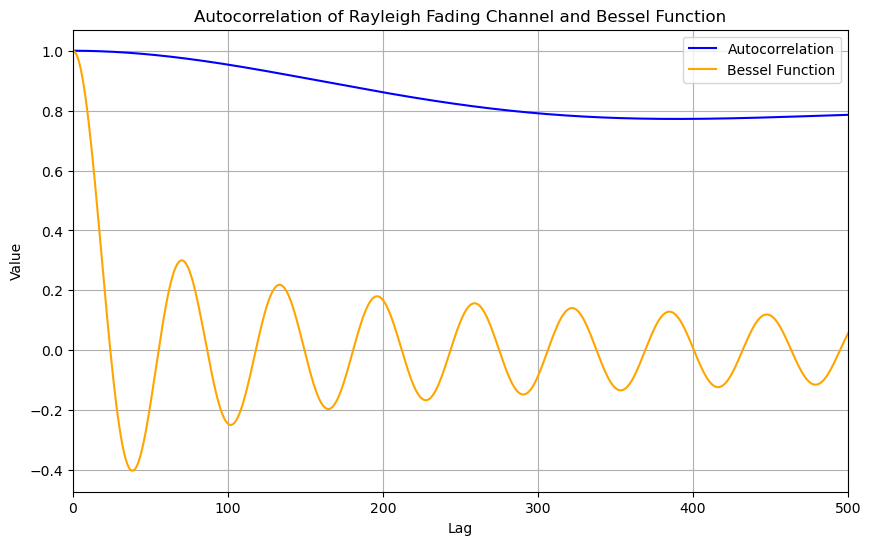

In [8]:
# Parameters
from scipy.special import jv 
Fs = 100000  # Sampling frequency
Fc = 2e9   # Carrier frequency
Fd = 100   # Doppler frequency
N = 100000  # Total number of symbols
M = 1      # Number of independent channels
snr_db = 10  # SNR in dB
packet_size = 100  # Size of each packet
header_packet_size = 20  # Known part of the signal (header)

# Generate the channel
channel = generate_rayleigh_channel(N, Fd, Fs).flatten()

# Compute autocorrelation
autocorr_result = autocorr(np.abs(channel))
autocorr_result/=np.max(np.abs(autocorr_result))

# Generate Bessel function
lag = np.arange(len(autocorr_result))
bessel_function = jv(0, lag / 10)  # Bessel function of the first kind, order 0

# Plot autocorrelation and Bessel function
plt.figure(figsize=(10, 6))
plt.plot(autocorr_result, label='Autocorrelation', color='blue')
plt.plot(bessel_function, label='Bessel Function', color='orange')
plt.title('Autocorrelation of Rayleigh Fading Channel and Bessel Function')
plt.xlabel('Lag')
plt.ylabel('Value')
plt.grid(True)
plt.xlim(0, 500)  # Adjust x-axis limit as needed
plt.legend()
plt.show()
    


In [9]:
def main():
    # Parameters
    Fs = 1000  # Sampling frequency
    Fc = 2e9     # Carrier frequency
    Fd = 10*(100 / Fs)     # Doppler frequency
    N = 100000   # Total number of symbols
    M = 1        # Number of independent channels
    snr_db = 10  # SNR in dB
    Tc = 1 / (1000*Fd)  # Coherence time based on Doppler frequency
    packet_size = 100  # Size of each packet
    header_packet_size = 20 # Known part of the signal (header)

    calculate_ber_mse(M, N, Fd, Fs, packet_size, header_packet_size, snr_db)

if __name__ == "__main__":
    main()

BER at 10 dB: 0.014712500
MSE at 10 dB: 0.006453085


# AR model without adjustment of parameters - attempt 1

In [11]:
from statsmodels.tsa.ar_model import AutoReg

In [12]:
def channel_to_mag_phase(channel):
    return np.abs(channel), np.angle(channel)

def train_ar_model(data, order):
    model = AutoReg(data, lags=order)
    model_fit = model.fit()
    return model_fit

def predict_channel(model, steps):
    return model.forecast(steps=steps)

def simulate_transmission(Fd, Fs, N, packet_size, header_size, snr_db, threshold, initial_header_packets):
    channel = generate_rayleigh_channel(N, Fd, Fs).flatten()
    mag, phase = channel_to_mag_phase(channel)
    
    signal = generate_bpsk_signal(N)
    num_packets = N // packet_size
    
    segment_headers = 0
    segment_non_headers = 0
    total_segments = 0
    total_frequency = 0
    breaks = 0
    packet_idx = 0
    
    while packet_idx < num_packets:
        #Start of a new segment
        segment_headers = 0
        segment_non_headers = 0
        segment_mse = 0
        segment_ber = 0
        
        # Send initial header packets
        for _ in range(initial_header_packets):
            if packet_idx >= num_packets:
                break
            
            start = packet_idx * packet_size
            end = start + packet_size
            
            packet_signal = signal[start:end]
            packet_channel = channel[start:end]
            
            transmitted_signal = packet_signal * packet_channel
            noisy_signal = add_noise(transmitted_signal, snr_db)
            
            # Perform least squares estimation for complex numbers
            H = np.column_stack([packet_signal[:header_size].real, packet_signal[:header_size].imag])
            h_noisy = np.column_stack([noisy_signal[:header_size].real, noisy_signal[:header_size].imag])
            channel_estimated = lstsq(H, h_noisy, rcond=None)[0]
            channel_estimated = channel_estimated[0] + 1j * channel_estimated[1]
            channel_estimated = np.full(noisy_signal.shape, channel_estimated[0] + 1j * channel_estimated[1])
            
            equalized_signal = noisy_signal * np.conj(channel_estimated) / (np.abs(channel_estimated)**2)
            demodulated_signal = bpsk_demodulate(equalized_signal)
            
            mse = np.mean(np.abs(packet_channel[:header_size] - channel_estimated[:header_size]) ** 2)
            ber = compute_ber(packet_signal[header_size:], demodulated_signal[header_size:])
            
            segment_mse += mse
            segment_ber += ber * (packet_size - header_size)
            segment_headers += 1
            packet_idx += 1
        
        # Train AR model on magnitude and phase
        mag_model = train_ar_model(mag[start:end], order=25)
        phase_model = train_ar_model(phase[start:end], order=25)
        
        # Predict and transmit non-header packets
        while True:
            if packet_idx >= num_packets:
                break
            
            start = packet_idx * packet_size
            end = start + packet_size
            
            predicted_mag = predict_channel(mag_model, steps=packet_size)
            predicted_phase = predict_channel(phase_model, steps=packet_size)
            predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
            
            packet_signal = signal[start:end]
            actual_channel = channel[start:end]
            
            transmitted_signal = packet_signal * predicted_channel
            noisy_signal = add_noise(transmitted_signal, snr_db)
            
            equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)
            demodulated_signal = bpsk_demodulate(equalized_signal)
            
            mse = np.mean(np.abs(actual_channel[:header_size] - predicted_channel[:header_size]) ** 2)
            ber = compute_ber(packet_signal, demodulated_signal)
            
            segment_mse += mse
            segment_ber += ber * packet_size
            segment_non_headers += 1
            
            if mse > threshold:
                breaks += 1
                break
            
            packet_idx += 1
        
        total_segments += 1
    return breaks*initial_header_packets/num_packets

Doppler frequency: 20 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 30 Hz, Average frequency of pilot transmission: 0.9920


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 40 Hz, Average frequency of pilot transmission: 0.9920


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 50 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 60 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 70 Hz, Average frequency of pilot transmission: 0.9840


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 80 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 90 Hz, Average frequency of pilot transmission: 0.9840


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\418721

Doppler frequency: 100 Hz, Average frequency of pilot transmission: 0.9840


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\t

Doppler frequency: 110 Hz, Average frequency of pilot transmission: 0.9840


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 120 Hz, Average frequency of pilot transmission: 0.9840


C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4245346343.py:50: RuntimeWarning: overflow encountered in square
  signal_power = np.mean(np.abs(signal) ** 2)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in multiply
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: overflow encountered in square
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 130 Hz, Average frequency of pilot transmission: 0.9840


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 140 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 150 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 160 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 170 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 180 Hz, Average frequency of pilot transmission: 0.9920


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 190 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 200 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 210 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 220 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 230 Hz, Average frequency of pilot transmission: 0.9920


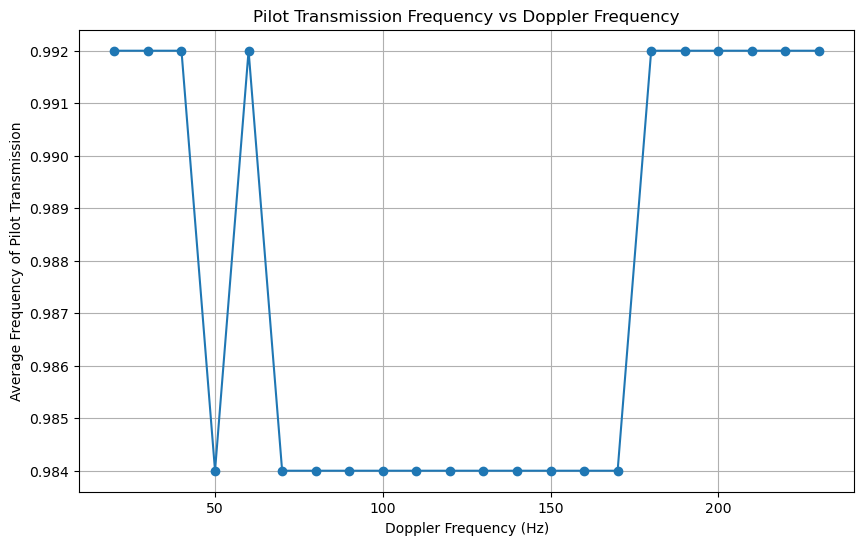

In [13]:
def main():
    Fs = 10000  # Sampling frequency
    N = 100000  # Total number of symbols
    packet_size = 80
    header_size = 20
    snr_db = 10
    threshold = 0.1
    initial_header_packets = 10
    
    doppler_frequencies = np.arange(20, 240, 10)
    avg_frequencies = []
    
    for Fd in doppler_frequencies:
        avg_freq = simulate_transmission(Fd, Fs, N, packet_size, header_size, snr_db, threshold, initial_header_packets)
        avg_frequencies.append(avg_freq)
        print(f"Doppler frequency: {Fd} Hz, Average frequency of pilot transmission: {avg_freq:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(doppler_frequencies, avg_frequencies, marker='o')
    plt.xlabel('Doppler Frequency (Hz)')
    plt.ylabel('Average Frequency of Pilot Transmission')
    plt.title('Pilot Transmission Frequency vs Doppler Frequency')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


# AR Model without adjustment of parameters - Attempt 2

C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 20 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 30 Hz, Average frequency of pilot transmission: 0.9920


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\t

Doppler frequency: 40 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 50 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 60 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 70 Hz, Average frequency of pilot transmission: 0.9840


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 80 Hz, Average frequency of pilot transmission: 0.9760


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 90 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 100 Hz, Average frequency of pilot transmission: 0.9920


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 110 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 120 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 130 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 140 Hz, Average frequency of pilot transmission: 0.9840


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 150 Hz, Average frequency of pilot transmission: 0.9840


C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)


Doppler frequency: 160 Hz, Average frequency of pilot transmission: 0.9840
Doppler frequency: 170 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 180 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 190 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 200 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 210 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 220 Hz, Average frequency of pilot transmission: 0.9920
Doppler frequency: 230 Hz, Average frequency of pilot transmission: 0.9920


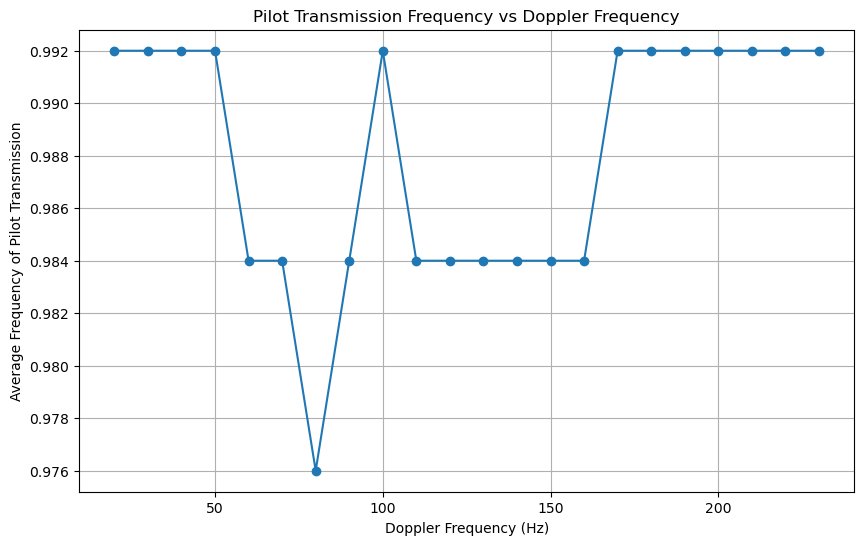

In [15]:
#Do not run
def main():
    Fs = 10000  # Sampling frequency
    Fc = 2e9     # Carrier frequency   
    N = 100000   # Total number of symbols
    M = 1        # Number of independent channels
    snr_db = 10  # SNR in dB
    packet_size = 80
    header_size = 20
    snr_db = 10
    threshold = 0.1
    initial_header_packets = 10
    doppler_frequencies = np.arange(20, 240, 10)
    avg_frequencies = []
    
    for Fd in doppler_frequencies:
        avg_freq = simulate_transmission(Fd, Fs, N, packet_size, header_size, snr_db, threshold, initial_header_packets)
        avg_frequencies.append(avg_freq)
        print(f"Doppler frequency: {Fd} Hz, Average frequency of pilot transmission: {avg_freq:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(doppler_frequencies, avg_frequencies, marker='o')
    plt.xlabel('Doppler Frequency (Hz)')
    plt.ylabel('Average Frequency of Pilot Transmission')
    plt.title('Pilot Transmission Frequency vs Doppler Frequency')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

# AR Prediction - version 2

In [24]:
def channel_to_mag_phase(channel):
    return np.abs(channel), np.angle(channel)

def train_ar_model(data, order):
    if isinstance(data, list) and len(data) > 0:
        # If data is a list, convert it to a numpy array
        data = np.array(data)
    
    if data.ndim == 1:
        # If data is 1-dimensional, use it as is
        model = AutoReg(data, lags=order)
    else:
        # If data is multi-dimensional, use the first column
        model = AutoReg(data[:, 0], lags=order)
    
    model_fit = model.fit()
    return model_fit

def predict_channel(model, steps):
    return model.forecast(steps=steps)

def simulate_transmission_rd(Fd, Fs, N, packet_size, header_size, snr_db, threshold, initial_header_packets):
    channel = generate_rayleigh_channel(N, Fd, Fs).flatten()
    mag, phase = channel_to_mag_phase(channel)
    
    signal = generate_bpsk_signal(N)
    num_packets = N // packet_size
    total_segments = 0
    total_frequency = 0
    breaks = 0
    packet_idx = 0

    while packet_idx < num_packets:
        # Start of a new segment
        segment_headers = 0
        segment_non_headers = 0
        
        # Lists to store past header magnitudes and phases for the current segment
        mag2 = []
        phase2 = []

        # Send initial header packets
        for _ in range(initial_header_packets):
            if packet_idx >= num_packets:
                break
            
            start = packet_idx * packet_size
            end = start + packet_size
            
            packet_signal = signal[start:end]
            packet_channel = channel[start:end]
            
            transmitted_signal = packet_signal * packet_channel
            noisy_signal = add_noise(transmitted_signal, snr_db)
            
            # Perform least squares estimation for complex numbers
            H = np.column_stack([packet_signal[:header_size].real, packet_signal[:header_size].imag])
            h_noisy = np.column_stack([noisy_signal[:header_size].real, noisy_signal[:header_size].imag])
            channel_estimated = lstsq(H, h_noisy, rcond=None)[0]
            channel_estimated = channel_estimated[0] + 1j * channel_estimated[1]
            channel_estimated = np.full(packet_signal.shape, channel_estimated[0] + 1j * channel_estimated[1])
            
            # Convert to magnitude and phase and store
            m, p = channel_to_mag_phase(channel_estimated)
            mag2.extend(m)
            phase2.extend(p)
            segment_headers += 1
            packet_idx += 1
        
        # Train AR model on the past magnitudes and phases of the current segment
        mag_model = train_ar_model(mag2, order=10)
        phase_model = train_ar_model(phase2, order=10)
        
        # Predict and transmit packets
        while True:
            if packet_idx >= num_packets:
                break
            
            start = packet_idx * packet_size
            end = start + packet_size
            
            # Predict the next channel using the AR model
            predicted_mag = predict_channel(mag_model, steps=1)
            predicted_phase = predict_channel(phase_model, steps=1)
            predicted_channel = mag_phase_to_complex(predicted_mag, predicted_phase)
            
            packet_signal = signal[start:end]
            actual_channel = channel[start:end]
            
            transmitted_signal = packet_signal * predicted_channel
            noisy_signal = add_noise(transmitted_signal, snr_db)
            
            equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)
            demodulated_signal = bpsk_demodulate(equalized_signal)
            
            # Calculate BER
            mse = np.mean(np.abs(actual_channel[:header_size] - predicted_channel[:header_size]) ** 2)
            ber = compute_ber(packet_signal, demodulated_signal)
            segment_non_headers += 1
            
            # Check BER against threshold
            if mse > threshold:
                breaks += 1
                break  # Exit the loop if BER crosses the threshold
            
            packet_idx += 1
        
        # After exiting the while loop due to high BER, reset and retrain
        total_segments += 1
        total_frequency += segment_headers / (segment_headers + segment_non_headers) if (segment_headers + segment_non_headers) > 0 else 0
        
    
    return breaks/num_packets

In [26]:
"""
channel = generate_rayleigh_channel(10, Fd, Fs)
mag, phase = channel_to_mag_phase(channel)
signal = generate_bpsk_signal(N)
print(signal)

Fd = 30 
Fs = 10
N = 20
initial_header_packets = 4
ber_threshold = 0.001
snr_db = 1000
header_size = 1
packet_size = 2

# Correct function call without extra parentheses
print(simulate_transmission(Fd, Fs, N, packet_size, header_size, snr_db, ber_threshold, initial_header_packets))
"""

'\nchannel = generate_rayleigh_channel(10, Fd, Fs)\nmag, phase = channel_to_mag_phase(channel)\nsignal = generate_bpsk_signal(N)\nprint(signal)\n\nFd = 30 \nFs = 10\nN = 20\ninitial_header_packets = 4\nber_threshold = 0.001\nsnr_db = 1000\nheader_size = 1\npacket_size = 2\n\n# Correct function call without extra parentheses\nprint(simulate_transmission(Fd, Fs, N, packet_size, header_size, snr_db, ber_threshold, initial_header_packets))\n'

Doppler frequency: 20 Hz, Average frequency of pilot transmission: 0.0730
Doppler frequency: 30 Hz, Average frequency of pilot transmission: 0.0650
Doppler frequency: 40 Hz, Average frequency of pilot transmission: 0.0820
Doppler frequency: 50 Hz, Average frequency of pilot transmission: 0.0870
Doppler frequency: 60 Hz, Average frequency of pilot transmission: 0.0900
Doppler frequency: 70 Hz, Average frequency of pilot transmission: 0.0920
Doppler frequency: 80 Hz, Average frequency of pilot transmission: 0.0920
Doppler frequency: 90 Hz, Average frequency of pilot transmission: 0.0940
Doppler frequency: 100 Hz, Average frequency of pilot transmission: 0.0930
Doppler frequency: 110 Hz, Average frequency of pilot transmission: 0.0930
Doppler frequency: 120 Hz, Average frequency of pilot transmission: 0.0950
Doppler frequency: 130 Hz, Average frequency of pilot transmission: 0.0980
Doppler frequency: 140 Hz, Average frequency of pilot transmission: 0.0960
Doppler frequency: 150 Hz, Averag

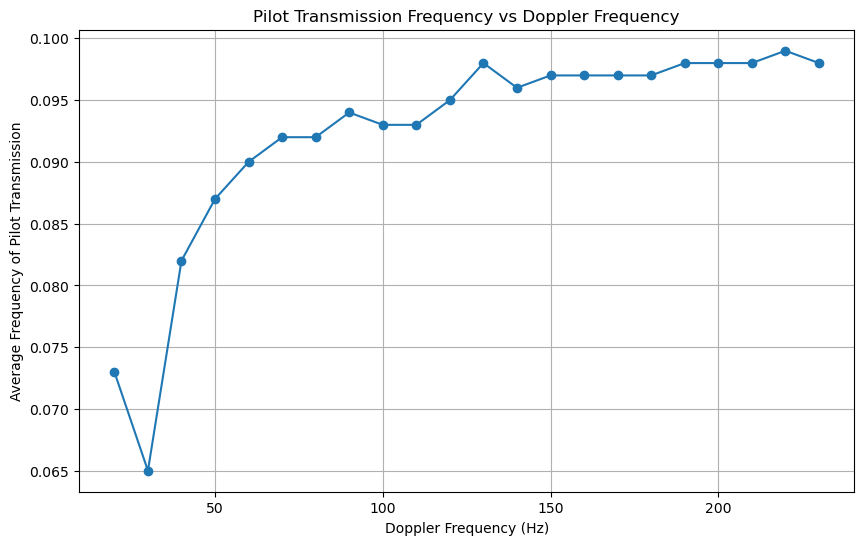

In [28]:
def mag_phase_to_complex(magnitude, phase):
    """Convert magnitude and phase to complex representation."""
    return magnitude * np.exp(1j * phase)
def main():
    # Signal and channel parameters (as per your input)
    Fs = 100000    # Sampling frequency
    Fc = 2e9       # Carrier frequency
    N = 100000     # Number of data points in the signal
    M = 1          # Number of different channel values (multi-path)
    snr_db = 10    # SNR in dB
    threshold = 0.1 # BER threshold for segment termination
    packet_size = 100
    header_packet_size = 20
    initial_header_packets = 10  # Initial packets with headers

    doppler_frequencies = np.arange(20, 240, 10)
    avg_frequencies = []
    
    for Fd in doppler_frequencies:
        avg_freq = simulate_transmission_rd(Fd, Fs, N, packet_size, header_packet_size, snr_db, threshold, initial_header_packets)
        avg_frequencies.append(avg_freq)
        print(f"Doppler frequency: {Fd} Hz, Average frequency of pilot transmission: {avg_freq:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(doppler_frequencies, avg_frequencies, marker='o')
    plt.xlabel('Doppler Frequency (Hz)')
    plt.ylabel('Average Frequency of Pilot Transmission')
    plt.title('Pilot Transmission Frequency vs Doppler Frequency')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

# AR Model with adjustment

In [30]:
def simulate_transmission2(Fd, Fs, N, packet_size, header_size, snr_db, threshold, initial_header_packets):
    channel = generate_rayleigh_channel(N, Fd, Fs).flatten()
    mag, phase = channel_to_mag_phase(channel)
    
    signal = generate_bpsk_signal(N)
    num_packets = N // packet_size
    segment_headers = 0
    segment_non_headers = 0
    total_segments = 0
    total_frequency = 0
    breaks = 0
    packet_idx = 0
    while packet_idx < num_packets:
        # Start of a new segment
        segment_headers = 0
        segment_non_headers = 0
        segment_mse = 0
        segment_ber = 0
        
        # Send initial header packets
        for _ in range(initial_header_packets):
            if packet_idx >= num_packets:
                break
            
            start = packet_idx * packet_size
            end = start + packet_size
            
            packet_signal = signal[start:end]
            packet_channel = channel[start:end]
            
            transmitted_signal = packet_signal * packet_channel
            noisy_signal = add_noise(transmitted_signal, snr_db)
            
            # Perform least squares estimation for complex numbers
            H = np.column_stack([packet_signal[:header_size].real, packet_signal[:header_size].imag])
            h_noisy = np.column_stack([noisy_signal[:header_size].real, noisy_signal[:header_size].imag])
            channel_estimated = lstsq(H, h_noisy, rcond=None)[0]
            channel_estimated = channel_estimated[0] + 1j * channel_estimated[1]
            channel_estimated = np.full(noisy_signal.shape, channel_estimated[0] + 1j * channel_estimated[1])
            
            equalized_signal = noisy_signal * np.conj(channel_estimated) / (np.abs(channel_estimated)**2)
            demodulated_signal = bpsk_demodulate(equalized_signal)
            
            mse = np.mean(np.abs(packet_channel[:header_size] - channel_estimated[:header_size]) ** 2)
            ber = compute_ber(packet_signal[header_size:], demodulated_signal[header_size:])
            
            segment_mse += mse
            segment_ber += ber * (packet_size - header_size)
            segment_headers += 1
            packet_idx += 1
        
        # Train AR model on magnitude and phase
        mag_model = train_ar_model(mag[start:end], order=5)
        phase_model = train_ar_model(phase[start:end], order=5)
        
        # Predict and transmit non-header packets
        while packet_idx < num_packets:
            start = packet_idx * packet_size
            end = start + packet_size
            
            # Use AR model to predict the channel for the header
            predicted_mag = predict_channel(mag_model, steps=header_size)
            predicted_phase = predict_channel(phase_model, steps=header_size)
            predicted_channel_header = predicted_mag * np.exp(1j * predicted_phase)
            
            packet_signal = signal[start:end]
            actual_channel = channel[start:end]
            
            # Estimate the header using predicted channel
            transmitted_signal_header = packet_signal[:header_size] * predicted_channel_header
            noisy_signal_header = add_noise(transmitted_signal_header, snr_db)
            equalized_signal_header = noisy_signal_header * np.conj(predicted_channel_header) / (np.abs(predicted_channel_header)**2)
            demodulated_signal_header = bpsk_demodulate(equalized_signal_header)
            
            # Use the estimated header for the rest of the packet
            channel_estimated_rest = actual_channel[header_size:]  # Use true channel for the rest (for simulation purposes)
            transmitted_signal_rest = packet_signal[header_size:] * channel_estimated_rest
            noisy_signal_rest = add_noise(transmitted_signal_rest, snr_db)
            
            # Combine header and rest for final estimation
            final_noisy_signal = np.concatenate((noisy_signal_header, noisy_signal_rest))
            equalized_signal_rest = final_noisy_signal[header_size:] * np.conj(channel_estimated_rest) / (np.abs(channel_estimated_rest)**2)
            demodulated_signal_rest = bpsk_demodulate(equalized_signal_rest)
            
            mse = np.mean(np.abs(actual_channel[:header_size] - predicted_channel_header) ** 2)
            ber = compute_ber(packet_signal, np.concatenate((demodulated_signal_header, demodulated_signal_rest)))
            
            segment_mse += mse
            segment_ber += ber * packet_size
            segment_non_headers += 1
            
            # Update packet index
            packet_idx += 1
            
            # Check if MSE exceeds threshold to start a new segment
            if ber > threshold:
                breaks += 1
                break
        
        total_segments += 1
        total_frequency += segment_headers / (segment_headers + segment_non_headers)
    
    return breaks / num_packets


Doppler frequency: 20 Hz, Average frequency of pilot transmission: 0.0300
Doppler frequency: 30 Hz, Average frequency of pilot transmission: 0.0500
Doppler frequency: 40 Hz, Average frequency of pilot transmission: 0.0570
Doppler frequency: 50 Hz, Average frequency of pilot transmission: 0.0660
Doppler frequency: 60 Hz, Average frequency of pilot transmission: 0.0700
Doppler frequency: 70 Hz, Average frequency of pilot transmission: 0.0730
Doppler frequency: 80 Hz, Average frequency of pilot transmission: 0.0730
Doppler frequency: 90 Hz, Average frequency of pilot transmission: 0.0750
Doppler frequency: 100 Hz, Average frequency of pilot transmission: 0.0720
Doppler frequency: 110 Hz, Average frequency of pilot transmission: 0.0750
Doppler frequency: 120 Hz, Average frequency of pilot transmission: 0.0740
Doppler frequency: 130 Hz, Average frequency of pilot transmission: 0.0770
Doppler frequency: 140 Hz, Average frequency of pilot transmission: 0.0770
Doppler frequency: 150 Hz, Averag

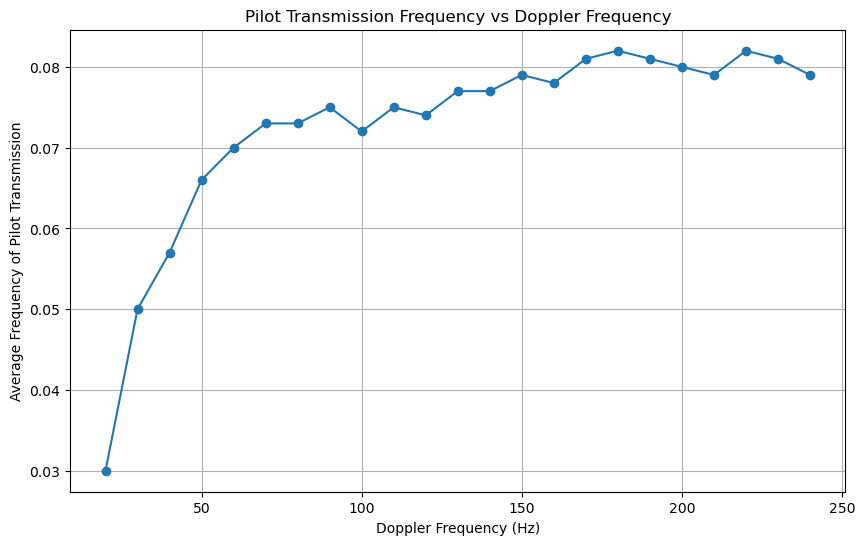

In [31]:
def main():
    # Signal and channel parameters (as per your input)
    Fs = 10000    # Sampling frequency
    Fc = 2e9       # Carrier frequency
    N = 100000     # Number of data points in the signal
    M = 1         # Number of different channel values (multi-path)
    packet_size = 100
    header_packet_size = 20
    snr_db = 10    # SNR in dB
    threshold = 0.01  # BER threshold for segment termination
    initial_header_packets = 10  # Initial packets with headers

    doppler_frequencies = np.arange(20, 241, 10)  # Updated range to 240 Hz
    avg_frequencies = []
    
    for Fd in doppler_frequencies:
        avg_freq = simulate_transmission2(Fd, Fs, N, packet_size, header_packet_size, snr_db, threshold, initial_header_packets)
        avg_frequencies.append(avg_freq)
        print(f"Doppler frequency: {Fd} Hz, Average frequency of pilot transmission: {avg_freq:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(doppler_frequencies, avg_frequencies, marker='o')
    plt.xlabel('Doppler Frequency (Hz)')
    plt.ylabel('Average Frequency of Pilot Transmission')
    plt.title('Pilot Transmission Frequency vs Doppler Frequency')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

# Plotting our 3 approaches together

C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: invalid value encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:79: RuntimeWarning: invalid value encountered in multiply
  predicted_channel = predicted_mag * np.exp(1j * predicted_phase)
C:\Users\vigne\AppData\Local\Temp\ipykernel_18160\4187217356.py:87: RuntimeWarning: invalid value encountered in divide
  equalized_signal = noisy_signal * np.conj(predicted_channel) / (np.abs(predicted_channel)**2)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\ar_model.py:686: RuntimeWarning: overflow encountered in matmul
  forecasts[i] = np.squeeze(new_x[i : i + 1] @ params)
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\t

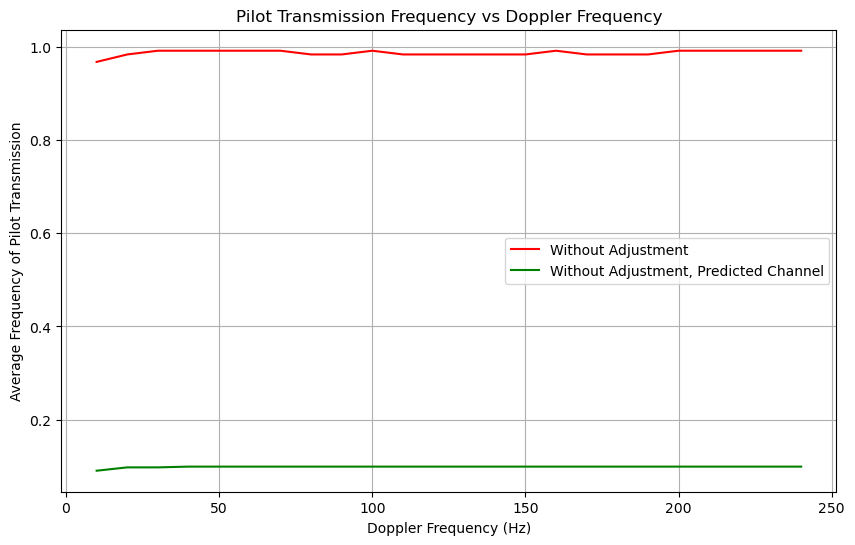

In [33]:
def main():
    # Signal and channel parameters (as per your input)
    Fs = 10000    # Sampling frequency
    Fc = 2e9       # Carrier frequency
    N = 100000     # Number of data points in the signal
    M = 1         # Number of different channel values (multi-path)
    packet_size = 80  # Size of each packet
    header_packet_size = 20  # Known part of the signal (header)
    snr_db = 10    # SNR in dB
    threshold = 0.1  # BER threshold for segment termination
    initial_header_packets = 10  # Initial packets with headers

    doppler_frequencies = np.arange(10, 241, 10)  # Updated range to 240 Hz
    avg_frequencies0 = []
    avg_frequencies1 = []
    avg_frequencies2 = []
    avg_frequencies_rd = []
    
    for Fd in doppler_frequencies:
        avg_freq = simulate_transmission(Fd, Fs, N, packet_size, header_packet_size, snr_db, threshold, initial_header_packets)
        avg_freqrd = simulate_transmission_rd(Fd, Fs, N, packet_size, header_packet_size, snr_db, threshold, initial_header_packets)
        avg_freq2 = simulate_transmission2(Fd, Fs, N, packet_size, header_packet_size, snr_db, threshold, initial_header_packets)
        avg_frequencies1.append(avg_freq)
        avg_frequencies2.append(avg_freq2)
        avg_frequencies_rd.append(avg_freqrd)
    
    plt.figure(figsize=(10, 6))
    plt.plot(doppler_frequencies, avg_frequencies1, color='r', label='Without Adjustment')
    plt.plot(doppler_frequencies, avg_frequencies_rd, color = "g", label='Without Adjustment, Predicted Channel')
    plt.xlabel('Doppler Frequency (Hz)')
    plt.ylabel('Average Frequency of Pilot Transmission')
    plt.title('Pilot Transmission Frequency vs Doppler Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()